# ZILLOW

# Acquire

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.impute
import os
from sklearn.model_selection import train_test_split
from env import host, user, password
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Creating a string that connects me to MySQLWorkbench

def get_connection(db, user=user, host=host, password=password):
    '''
    get_connection uses login info from env.py file to access Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'
    

**I imported specific usefulcolumns based on the experience I had using this dataframe in previous assignment from the data science team**

In [3]:
# Getting the data from the Codeup database

def get_zillow_data():
    '''
    zillow_data() gets the zillow (only properties_2017 table) data from Codeup db, then writes it to a csv file,
    and returns the DF.
    '''
    # Creating a SQL query
    sql_query = '''
                SELECT
      properties_2017.parcelid,
      bathroomcnt,
      bedroomcnt,
      propertylandusedesc,
      calculatedfinishedsquarefeet,
      fips,
      latitude,
      longitude,  
      lotsizesquarefeet,
      yearbuilt, 
      structuretaxvaluedollarcnt,
      taxvaluedollarcnt, 
      landtaxvaluedollarcnt,
      taxamount,                      
      predictions_2017.logerror,                       
      predictions_2017.transactiondate
   FROM properties_2017
   JOIN predictions_2017 USING(parcelid)
   LEFT JOIN airconditioningtype USING(airconditioningtypeid)
   LEFT JOIN architecturalstyletype USING(architecturalstyletypeid)
   LEFT JOIN buildingclasstype USING(buildingclasstypeid)
   LEFT JOIN heatingorsystemtype USING(heatingorsystemtypeid)
   LEFT JOIN propertylandusetype USING(propertylandusetypeid)
   LEFT JOIN storytype USING(storytypeid)
   LEFT JOIN typeconstructiontype USING(typeconstructiontypeid)
   WHERE
      latitude IS NOT NULL
      AND longitude IS NOT NULL
      AND propertylandusedesc = 'Single Family Residential';
                '''
    
    # Reading in the DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    return df

In [4]:
# Assigning the dataframe to a variable and displaying of it to have a first look

houses = get_zillow_data()
houses.head()

,parcelid,bathroomcnt,bedroomcnt,propertylandusedesc,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
0,14297519,3.5,4.0,Single Family Residential,3100.0,6059.0,33634931.0,-117869207.0,4506.0,1998.0,485713.0,1023282.0,537569.0,11013.72,0.025595,2017-01-01
1,17052889,1.0,2.0,Single Family Residential,1465.0,6111.0,34449266.0,-119281531.0,12647.0,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01
2,14186244,2.0,3.0,Single Family Residential,1243.0,6059.0,33886168.0,-117823170.0,8432.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,2017-01-01
3,12177905,3.0,4.0,Single Family Residential,2376.0,6037.0,34245180.0,-118240722.0,13038.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.103410,2017-01-01
4,12095076,3.0,4.0,Single Family Residential,2962.0,6037.0,34145202.0,-118179824.0,63000.0,1950.0,276684.0,773303.0,496619.0,9516.26,-0.001011,2017-01-01


In [5]:
# Displaying number of rows and columns

houses.shape

(52442, 16)

In [6]:
# Writing houses to csv on my computer

houses.to_csv('houses.csv')

In [7]:
# Displaying some general information about the data

houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52442 entries, 0 to 52441
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52442 non-null  int64  
 1   bathroomcnt                   52442 non-null  float64
 2   bedroomcnt                    52442 non-null  float64
 3   propertylandusedesc           52442 non-null  object 
 4   calculatedfinishedsquarefeet  52360 non-null  float64
 5   fips                          52442 non-null  float64
 6   latitude                      52442 non-null  float64
 7   longitude                     52442 non-null  float64
 8   lotsizesquarefeet             52073 non-null  float64
 9   yearbuilt                     52326 non-null  float64
 10  structuretaxvaluedollarcnt    52358 non-null  float64
 11  taxvaluedollarcnt             52441 non-null  float64
 12  landtaxvaluedollarcnt         52441 non-null  float64
 13  t

In [8]:
# Displaying statistical analysis of the data through.descibe()
# with astype('int64') to cut through all the noise of the float data
# displayed when using only 'houses.describe().T'

houses.describe().T.astype('int64')

,count,mean,std,min,25%,50%,75%,max
parcelid,52442,12999117,3411411,10711855,11510295,12577655,14129510,167687839
bathroomcnt,52442,2,1,0,2,2,3,18
bedroomcnt,52442,3,0,0,3,3,4,14
calculatedfinishedsquarefeet,52360,1922,1004,128,1268,1659,2306,21929
fips,52442,6049,21,6037,6037,6037,6059,6111
latitude,52442,34022538,273976,33340620,33826909,34023771,34187149,34818767
longitude,52442,-118194184,356661,-119475416,-118400683,-118153075,-117929152,-117554636
lotsizesquarefeet,52073,11339,86746,236,5583,6840,8798,6971010
yearbuilt,52326,1963,23,1878,1950,1961,1979,2016
structuretaxvaluedollarcnt,52358,196531,254338,129,77071,131807,226319,9164901


**<font color = 'blue'>Observations</font>**

><font color = 'blue'>There are still some null values</font>

><font color = 'blue'>The counties are designated by their respective numbers and need to be renamed</font>

><font color = 'blue'>Many columns need to be renamed for better readability</font>

><font color = 'blue'>Having the age of the house would help instead of the year built for better grouping</font>

**<font color = 'blue'>Actions</font>**

><font color = 'blue'>Check for duplicates and if there are some remove them</font>

><font color = 'blue'>Drop nulls</font>

><font color = 'blue'>Determine a threshhold to drop null value-ridden columns and drop them</font>

><font color = 'blue'>Detect and remove outliers if necessary unless going for MVP then wait to get MVP</font>

><font color = 'blue'>Create a county column with boolean and names for exploration and scaling</font>

><font color = 'blue'>Create a column for the houses' age</font>

><font color = 'blue'>Rename difficult to read columns</font>

# Prepare

In [9]:
# Dropping duplicates in rows if there are any and displaying the new count of columns and rows
houses.drop_duplicates(keep='first')

houses.shape

(52442, 16)

><font color = 'blue'>**There are no duplicates in the data**</font>

In [10]:
# Using a function that provides number of nulls and their percent in the data

def multi_frequency(df,vars):
    '''multi_frequency takes a dataframe in *arg and a *kwarg in the form of a list of columns
    and return a dataframe with the count and the frequency of the data
    '''
    frequency=df[vars].isnull().sum()
    percentage=df[vars].isnull().sum()*100/(len(df))
    df=pd.concat([frequency,percentage], axis=1, keys=['num_rows_missing', 'pct_rows_missing'])
    return df

In [11]:
# Displaying the distribution of nulls in a dataframe

multi_frequency(houses, houses.columns).sort_values(by='pct_rows_missing', ascending=False)

,num_rows_missing,pct_rows_missing
lotsizesquarefeet,369,0.703634
yearbuilt,116,0.221197
structuretaxvaluedollarcnt,84,0.160177
calculatedfinishedsquarefeet,82,0.156363
taxamount,4,0.007627
taxvaluedollarcnt,1,0.001907
landtaxvaluedollarcnt,1,0.001907
parcelid,0,0.000000
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000


**<font color = 'blue'>Conclusions</font>**

>**lotsizesquarefeet, yearbuilt, structuretaxvaluedollarcnt, and calculatedfinishedsquarefeet have the most nulls, I will use KNNImputer to handle them**

>**I will drop the null rows in taxamount, taxvaluedollarcnt, and landtaxvaluedollarcnt because there are very few of them**

>**<font color = 'brown'>I will impute at KNN=1 and KNN =2. If I have time I will run the explore, split, scale and model on data from imputing KNN=2</font>**

##### KNN = 1

In [12]:
# Handling missing values

def handle_missing_values(df):
    imputer = KNNImputer(n_neighbors=1)
    imputer.fit_transform(houses[['lotsizesquarefeet',
                                  'yearbuilt',
                                  'structuretaxvaluedollarcnt',
                                  'calculatedfinishedsquarefeet']])
    df = df.dropna()
    return df

In [13]:
houses_knn1 = handle_missing_values(houses)

In [14]:
multi_frequency(houses_knn1, houses_knn1.columns).sort_values(by='pct_rows_missing', ascending=False)

,num_rows_missing,pct_rows_missing
parcelid,0,0.0
bathroomcnt,0,0.0
bedroomcnt,0,0.0
propertylandusedesc,0,0.0
calculatedfinishedsquarefeet,0,0.0
fips,0,0.0
latitude,0,0.0
longitude,0,0.0
lotsizesquarefeet,0,0.0
yearbuilt,0,0.0


In [15]:
houses_knn1.shape

(51897, 16)

##### KNN = 2

In [16]:
def handle_missing_values2(df):
    imputer = KNNImputer(n_neighbors=2)
    imputer.fit_transform(houses[['lotsizesquarefeet',
                                  'yearbuilt',
                                  'structuretaxvaluedollarcnt',
                                  'calculatedfinishedsquarefeet']])
    df = df.dropna()
    return df

In [17]:
houses_knn2 = handle_missing_values(houses)

In [18]:
multi_frequency(houses_knn2, houses_knn2.columns).sort_values(by='pct_rows_missing', ascending=False)

,num_rows_missing,pct_rows_missing
parcelid,0,0.0
bathroomcnt,0,0.0
bedroomcnt,0,0.0
propertylandusedesc,0,0.0
calculatedfinishedsquarefeet,0,0.0
fips,0,0.0
latitude,0,0.0
longitude,0,0.0
lotsizesquarefeet,0,0.0
yearbuilt,0,0.0


##### I will continue my work with KNN = 1

In [19]:
houses_knn1.columns.tolist()

['parcelid',
 'bathroomcnt',
 'bedroomcnt',
 'propertylandusedesc',
 'calculatedfinishedsquarefeet',
 'fips',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'logerror',
 'transactiondate']

In [87]:
def prepare_zillow(df):
    '''
    Takes in the df and changes county numbers
    to a boolean column,  indicating county names 
    for properties and another one the age
    '''
# Creating df with counties as booleans
    counties = pd.get_dummies(df.fips)
    counties.columns = ['Los_Angeles', 'Orange', 'Ventura']
    df = pd.concat([df, counties], axis = 1)
# Dropping the propertylandusedesc column
    df.drop(columns=['propertylandusedesc'], inplace=True)
    df.drop(columns=['transactiondate'], inplace=True)
# Calculating age of home
# (will be useful when scaling but also maybe clustering as a 'new' feature)
    df['age'] = 2017 - df.yearbuilt
    df.drop(columns=['yearbuilt'], inplace=True)
    
# Renaming columns
    cols_to_rename = {
    'calculatedfinishedsquarefeet': 'habitable_sqft',
    'taxvaluedollarcnt': 'parcel_tax_value',
    'bedroomcnt': 'bedrooms',
    'bathroomcnt': 'bathrooms',
    'taxamount': 'tax_amount',
    'lotsizesquarefeet': 'lot_sqft',
    'structuretaxvaluedollarcnt': 'building_tax_value',
    'landtaxvaluedollarcnt': 'land_tax_value',
}
    df = df.rename(columns=cols_to_rename)
    return df

# I missed one column so I will rename it in another cell

In [88]:
# Assigning the renamed dataframe to a new one

houses_renamed=prepare_zillow(houses_knn1)

In [89]:
houses_renamed.shape

(51897, 17)

In [90]:
houses_renamed.columns.tolist()

['parcelid',
 'bathrooms',
 'bedrooms',
 'habitable_sqft',
 'fips',
 'latitude',
 'longitude',
 'lot_sqft',
 'building_tax_value',
 'parcel_tax_value',
 'land_tax_value',
 'tax_amount',
 'logerror',
 'Los_Angeles',
 'Orange',
 'Ventura',
 'age']

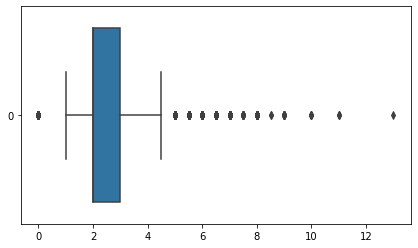

In [24]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.bathrooms, orient='h')
plt.show()

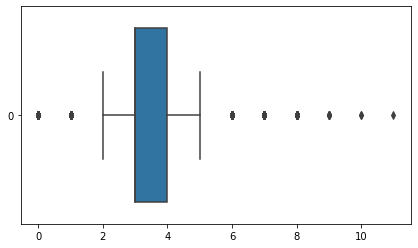

In [25]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.bedrooms, orient='h')
plt.show()

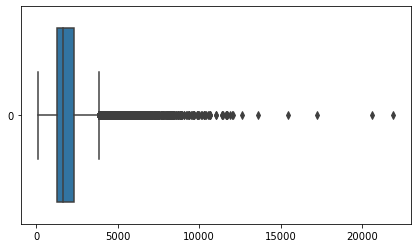

In [26]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.habitable_sqft, orient='h')
plt.show()

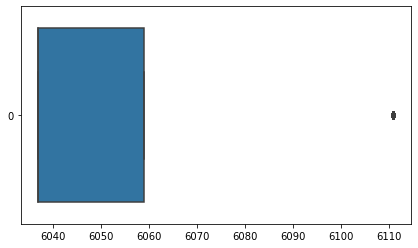

In [27]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.fips, orient='h')
plt.show()

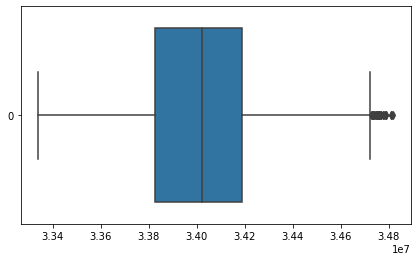

In [28]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.latitude, orient='h')
plt.show()

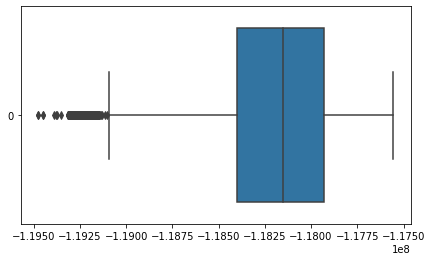

In [29]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.longitude, orient='h')
plt.show()

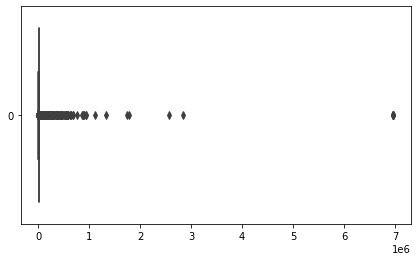

In [30]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.lot_sqft, orient='h')
plt.show()

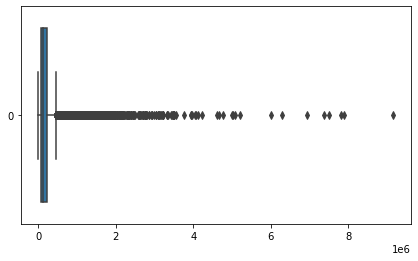

In [31]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.building_tax_value, orient='h')
plt.show()

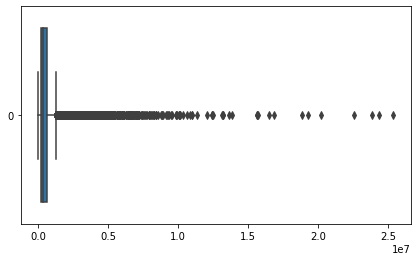

In [32]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.parcel_tax_value, orient='h')
plt.show()

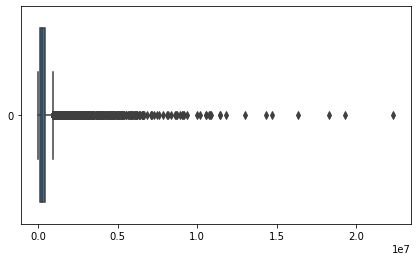

In [33]:

plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.land_tax_value, orient='h')
plt.show()

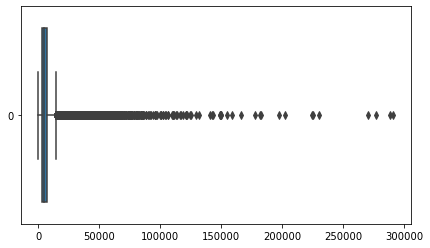

In [34]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.tax_amount, orient='h')
plt.show()

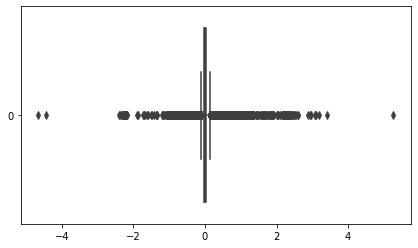

In [35]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.logerror, orient='h')
plt.show()

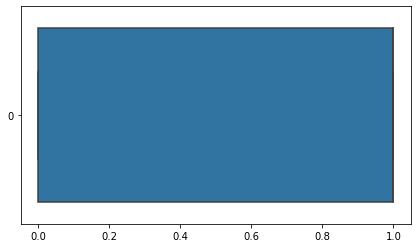

In [36]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.Los_Angeles, orient='h')
plt.show()

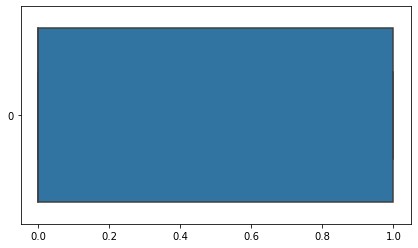

In [37]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.Orange, orient='h')
plt.show()

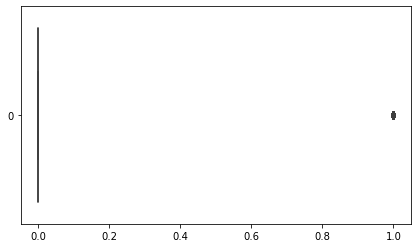

In [38]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.Ventura, orient='h')
plt.show()

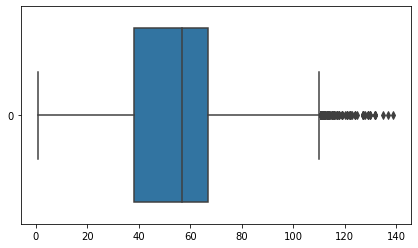

In [78]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.age, orient='h')
plt.show()

**<font color = 'blue'>Observations</font>**

><font color = 'blue'>All columns but Orange and Los Angeles have upper-bound outliers</font>

><font color = 'blue'>All columns but logerror, longitude, bathrooms, and bedrooms have lower-bound outliers</font>

**<font color = 'blue'>Actions</font>**

><font color = 'blue'>Detect outliers with a function in order to use that function to remove them</font>

><font color = 'blue'>Remove outlier</font>

><font color = 'brown'>In order to get to an MVP, I will skip the removal of outliers for now</font>

In [ ]:
# Detectecting outliers

def get_upper_outliers(s, k):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the
    series.

    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

In [ ]:
# Detectecting outliers

def get_lower_outliers(s, k):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the
    series.

    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    return s.apply(lambda x: max([x - lower_bound, 0]))

**<font color = 'blue'>Takeaways</font>**

><font color = 'blue'>Nulls have been removed</font>

><font color = 'blue'>Missing data imputed</font>

><font color = 'blue'>Split the data into train, validate, and test</font>

><font color = 'blue'>Scale and explore</font>

## Functions

# Exploration

**I will try to answer these questions in my exploration phase**

**My objective is to use the variables or a combination of them to understand**

><font color = 'blue'>Is there a pattern in the data? Where?</font>

><font color = 'brown'>I will explore parcel density,  to answer this question</font>
    
><font color = 'blue'>What features are driving the outcome? What are the most prominent ones?</font>

><font color = 'brown'>I will use --- to answer this question</font>

><font color = 'blue'>What features can I build from the ones I have that influence the target even more?</font>

><font color = 'brown'>I will use --- to answer this question</font>

>We want to walk away from exploration with with modeling strategies (feature selection, algorithm selection, evaluation methods, for example).

In [91]:
houses_renamed.shape

(51897, 17)

In [92]:
def split_zillow(df):
     
     # splits df into train_validate and test using train_test_split(), random state is set so that it is replicable
    train_validate, test = train_test_split(houses_renamed, test_size=.2, random_state=175)

    # splits train_validate into train and validate using train_test_split(), random state is set so that it is replicable
    train, validate = train_test_split(train_validate, 
                                        test_size=.3, 
                                        random_state=175)
    return train, validate, test

In [93]:
train, validate, test = split_zillow(houses_renamed)

In [94]:
train.shape

(29061, 17)

In [95]:
validate.shape

(12456, 17)

In [96]:
test.shape

(10380, 17)

In [101]:
def min_max_scaler(train, validate, test):
    '''Takes in train, validate, test then returns their copies 
    (copy set to True) scaled to positive integers
    '''
    scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(train)
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
    validate_scaled = pd.DataFrame(scaler.transform(validate), columns=validate.columns.values).set_index([validate.index.values])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
    return train_scaled, validate_scaled, test_scaled

In [102]:
train_scaled, validate_scaled, test_scaled = min_max_scaler(train, validate, test)

In [103]:
train_scaled.shape

(29061, 17)

In [106]:
train.head()

,parcelid,bathrooms,bedrooms,habitable_sqft,fips,latitude,longitude,lot_sqft,building_tax_value,parcel_tax_value,land_tax_value,tax_amount,logerror,Los_Angeles,Orange,Ventura,age
28102,11292068,1.0,3.0,1609.0,6037.0,34697424.0,-118121280.0,10368.0,50591.0,63237.0,12646.0,1552.13,-0.009191,1,0,0,60.0
39546,11262127,2.0,4.0,1711.0,6037.0,34651728.0,-118232360.0,10019.0,178661.0,222586.0,43925.0,3530.12,-0.002279,1,0,0,25.0
49654,11968015,1.0,2.0,772.0,6037.0,34110447.0,-118206705.0,4544.0,36448.0,182276.0,145828.0,2189.64,0.068814,1,0,0,92.0
15628,11756342,1.0,3.0,1756.0,6037.0,34057366.0,-118329619.0,7822.0,70340.0,353187.0,282847.0,4399.15,0.002592,1,0,0,93.0
29412,11184808,2.0,3.0,1218.0,6037.0,34616616.0,-118195529.0,8397.0,165345.0,206678.0,41333.0,3426.00,0.002827,1,0,0,22.0


array([[<AxesSubplot:title={'center':'parcelid'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'habitable_sqft'}>],
       [<AxesSubplot:title={'center':'fips'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'lot_sqft'}>],
       [<AxesSubplot:title={'center':'building_tax_value'}>,
        <AxesSubplot:title={'center':'parcel_tax_value'}>,
        <AxesSubplot:title={'center':'land_tax_value'}>,
        <AxesSubplot:title={'center':'tax_amount'}>],
       [<AxesSubplot:title={'center':'logerror'}>,
        <AxesSubplot:title={'center':'Los_Angeles'}>,
        <AxesSubplot:title={'center':'Orange'}>,
        <AxesSubplot:title={'center':'Ventura'}>],
       [<AxesSubplot:title={'center':'age'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

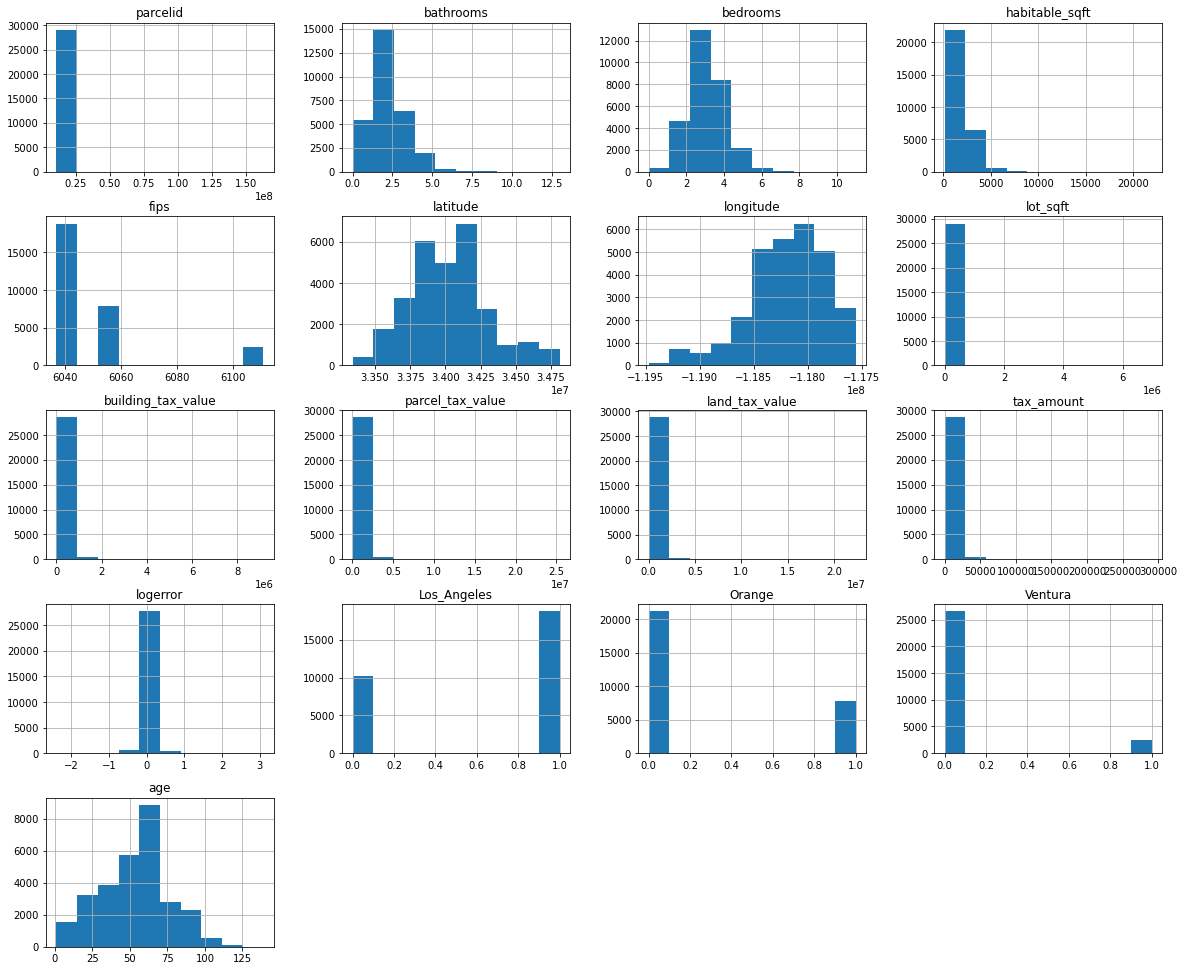

In [104]:
# Plotting histograms to visualize the data
train.hist(figsize=(20, 17))

**<font color = 'blue'>Observations</font>**

>**<font color = 'blue'>The data distribution is all over the place</font>**

>**<font color = 'blue'>Bathrooms, habitable_sqft, lot_sqft, building_tax_value, parcel_tax_value, land_tax_value, tax_amount, and logerror have the same right-skewed shape</font>**

>**<font color = 'blue'>Bedrooms, latitude, longitude and age have a pseudo-normal ditribution</font>**

**<font color = 'blue'>Questions</font>**

Does the location impact logerror?

